In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from deluca.agents import BPC, LQR, EBPC
from deluca.envs import LDS
import jax.numpy as jnp
import jax
import numpy as np

from jax.config import config
config.update("jax_debug_nans", True)
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/stephen/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
PRINT_RATE = 1000
def get_err(T, lds, controller, noise, random_key=jax.random.PRNGKey(42)):
    lds.reset()
    avg_err = 0
    err = 0
    err_list = []
    prev_noise = jnp.zeros(shape=lds.state.shape)
    key = random_key
    last_avg_err = 0
    for i in range(T):

        key, subkey = jax.random.split(key)
        try:
            action = controller(lds.obs, err)
        except:
            action = controller(lds.obs)
        lds.step(action)
        if noise == "Gaussian":
            lds.state += 0.03 * jax.random.normal(subkey, shape=lds.state.shape)
        elif noise == "Sinusoidal":
            lds.state += 0.03 * jnp.sin(i/(20 * np.pi))
        elif noise == "GaussianWalk":
            prev_noise = prev_noise + jax.random.normal(subkey, shape=lds.state.shape)
            lds.state += 0.03 * prev_noise / np.sqrt(T)
        elif noise == "None":
            pass
        else:
            raise ValueError("Noise type unrecognized!")
        err = (jnp.linalg.norm(lds.state)**2+jnp.linalg.norm(action)**2)
        last_avg_err += err
        if (i+1) % PRINT_RATE == 0:
            print(str(i+1) + " avg err:", last_avg_err/PRINT_RATE)
            last_avg_err = 0
        avg_err += err/T
        err_list += [err]
    return avg_err, np.array(err_list)

In [5]:
T = 100000

system = "DI" # one of "DI", "LargeSparse"
noise = "Sinusoidal" # one of "Gaussian", "GaussianWalk", "Sinusoidal", "None"

if system == "DI":
    A = jnp.array([[.9, .9], [-0.01, .9]])
    B = jnp.array([[0], [1]])
elif system == "LargeSparse":
    A = jnp.array([[.3, 0, 0, .4, .1], [0, .5, .5, .5, 0], [.05, .05, .05, .05, 0], [.3, 0, 0, 0, 0], [4, 0, 0, 0, .1]])
    B = jnp.array([[2, 0, 0], [0, .3, .1], [0, .1, .3], [0, 0, 0], [0, 0, 0]])
else:
    raise ValueError("System type unrecognized!")
#A,B = jnp.array([[.8,.5], [0,.8]]), jnp.array([[0],[0.8]])

use_K = True


In [19]:
bpc = BPC(A, B, lr_scale=1e-1, delta=1/T, decay=True, use_K=use_K)
bpc_avg_err, bpc_errs = get_err(T, LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), bpc, noise)
print("BPC incurs ", bpc_avg_err, " loss")

1000 avg err: 0.026202092114658623
2000 avg err: 0.02461808989484902
3000 avg err: 0.02470368206589346
4000 avg err: 0.024828792398839068
5000 avg err: 0.02497384669448702
6000 avg err: 0.025101496268263947
7000 avg err: 0.025192084596441833
8000 avg err: 0.02523733000795553
9000 avg err: 0.025217779997198618
10000 avg err: 0.02514914244287672
11000 avg err: 0.02503453257069185
12000 avg err: 0.024907753989228395
13000 avg err: 0.024778506304032492
14000 avg err: 0.0246743633420394
15000 avg err: 0.02460470343320171
16000 avg err: 0.0245907466780161
17000 avg err: 0.02462636472874788
18000 avg err: 0.024710865063079557
19000 avg err: 0.024833833763975993
20000 avg err: 0.024965219389795953
21000 avg err: 0.025085026053515983
22000 avg err: 0.025174892246361578
23000 avg err: 0.025224060718466938
24000 avg err: 0.02522008566189961
25000 avg err: 0.025157947210343288
26000 avg err: 0.025052601480809126
27000 avg err: 0.0249261931349453
28000 avg err: 0.02479621662722712
29000 avg err: 0.

In [23]:
lqr = LQR(A, B)
lqr_avg_err, lqr_errs = get_err(T, LDS(state_size= B.shape[0], action_size=B.shape[1], A=A, B=B), lqr, noise)
print("LQR incurs ", lqr_avg_err, " loss")

1000 avg err: 0.029263881911776063
2000 avg err: 0.02779187702451023
3000 avg err: 0.02789397280828979
4000 avg err: 0.028031658381145356
5000 avg err: 0.02818155233369009
6000 avg err: 0.0283182000609397
7000 avg err: 0.028418396397775218
8000 avg err: 0.0284651262603208
9000 avg err: 0.028450454103666947
10000 avg err: 0.028376871515670074
11000 avg err: 0.028256874101919193
12000 avg err: 0.028110839514176186
13000 avg err: 0.027963566970034118
14000 avg err: 0.027840065913653508
15000 avg err: 0.027761308976364356
16000 avg err: 0.027740670458426497
17000 avg err: 0.027781655139803674
18000 avg err: 0.027877303107456352
19000 avg err: 0.028011371669849624
20000 avg err: 0.028161093648997913
21000 avg err: 0.0283010436439961
22000 avg err: 0.02840745570712087
23000 avg err: 0.02846225921586611
24000 avg err: 0.02845614757951737
25000 avg err: 0.02839015866041972
26000 avg err: 0.02827549852686631
27000 avg err: 0.028131638467441655
28000 avg err: 0.027983008426939994
29000 avg err: 

In [25]:
ebpc = EBPC(
    A = A,
    B = B,
    C = None,
    T = T,
    H = 5,   # To change, but good for debug
    cost_bound = 1e5,
    rad = 3,
    beta = 5.0,
    sigma = 0.2,
    eta_mul = 3e6,
    grad_mul = 3e-4, # Typically wants to decrease as eta_mul increases to offset its effect
    use_K=True,
)
ebpc_avg_err, ebpc_errs = get_err(T, LDS(state_size=B.shape[0], action_size=B.shape[1], A=A, B=B), ebpc, noise)
print("BCOMC incurs ", ebpc_avg_err, " loss")

eta: 1.2427578366433574
1000 avg err: 0.487708934732059
2000 avg err: 0.02246440504394472
3000 avg err: 0.015312534005966886
4000 avg err: 0.014362125989364007
5000 avg err: 0.012003828171175837
6000 avg err: 0.01044039132815316
7000 avg err: 0.009640750724676074
8000 avg err: 0.009473982009403076
9000 avg err: 0.008713534282790824
10000 avg err: 0.008631710037028088
11000 avg err: 0.007973682007678584
12000 avg err: 0.0079681073090562
13000 avg err: 0.00765952619263281
14000 avg err: 0.007078539714631524
15000 avg err: 0.0071654248644793936
16000 avg err: 0.007015820640500579
17000 avg err: 0.006797033959901305
18000 avg err: 0.006859291453748896
19000 avg err: 0.006968208137960234
20000 avg err: 0.006861840633398482
21000 avg err: 0.00664544488952582
22000 avg err: 0.006607538443963786
23000 avg err: 0.006399961328886714
24000 avg err: 0.006173550266658793
25000 avg err: 0.006247979337732426
26000 avg err: 0.006334564791967494
27000 avg err: 0.006137129330562186
28000 avg err: 0.0061

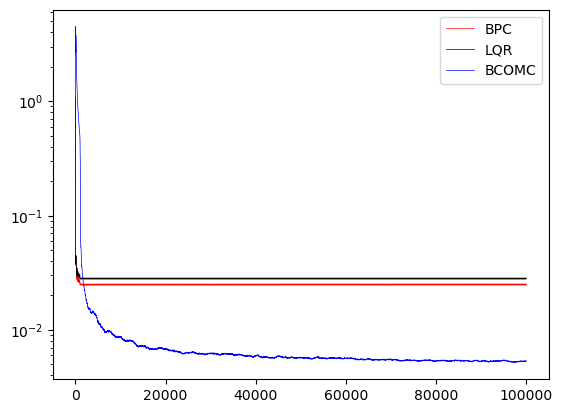

In [26]:
def mavg(data, period=1000):
    recent_sum = np.cumsum(data)
    recent_sum[period:] -= recent_sum[:-period]
    norm = np.cumsum(np.ones(data.shape))
    norm[period:] -= norm[:-period]
    return recent_sum / norm

import matplotlib.pyplot as plt
colors = {"BPC": "red", "LQR": "black", "EBPC": "blue"}
plt.plot(mavg(bpc_errs), label="BPC", color=colors["BPC"], linewidth=0.5)
plt.plot(mavg(lqr_errs), label="LQR", color=colors["LQR"], linewidth=0.5)
plt.plot(mavg(ebpc_errs), label="EBPC", color=colors["EBPC"], linewidth=0.5)
plt.legend()
plt.yscale('log')
plt.show()